In [332]:
import numpy as np
import sympy as sy
from copy import copy
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import comb
from functools import partial
import mcint
import random
import math
import scipy.integrate as sci
from scipy import stats
from numba import jit
from functools import partial
import vegas


In [122]:

def append_state(state, index_list, is_fermion = False, ne = 1):
    if is_fermion == True:
        my_sum = 0
        for i in copy(index_list):
            if i>1:
                return
            my_sum = my_sum+i
        if my_sum!=ne:
            return
    state.append(copy(index_list))
    return


def for_recursive(number_of_loops, range_list, state, current_index=0, iter_list = [], is_fermion = False, ne =0):
    if iter_list == []:
        iter_list = [0]*number_of_loops

    if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            append_state(state, iter_list, is_fermion, ne)
    else:
        for iter_list[current_index] in range_list[current_index]:
            for_recursive(number_of_loops, iter_list = iter_list, range_list = range_list,  current_index = current_index+1, state= state, is_fermion = is_fermion, ne =ne) 


#### Fock space


class state():
    
    def __init__(self, x,y,pre_factor=1, show=False):
        self.psi_e = x
        self.psi_ph =y
        self.pre_factor = pre_factor
        self.ev = []
        self.ew = []
        self.evT = []
        self.ewT = []
        if show:
            self.show()
        return
    
    def show(self, end=0):
        '''prints current state'''
        
        if self.pre_factor != 1:
            print(sy.S(str(f)), end ="")
        print("|", end ="")
        for e in range(len(self.psi_e)):
            if e == len(self.psi_e)-1:
                print(self.psi_e[e], end ="")
            else:
                print(self.psi_e[e], end =",")
        print(">",end ="")
        print(" |", end ="")
        for ph in range(len(self.psi_ph)):
            if ph == len(self.psi_ph)-1:
                print(self.psi_ph[ph], end ="")
            else:
                print(self.psi_ph[ph], end =",")
        if end==0:
            print(">")
        else:
            print(">", end =" ")
        return
    
    def number_of_phonons(self,j=-1):
        if j==-1:
            return sum(self.psi_ph)
        else:
            return self.psi_ph[j]
    
    def e_index(self,i):
        """returns periodic index i with periode n_e"""
        return i%self.n_e
    
    def C_plus(self,i):
        if self.psi_e[self.e_index(i)]== 0:
            self.psi_e[self.e_index(i)] = 1
        elif self.psi_e[self.e_index(i)]== 1:
            self.psi_e[self.e_index(i)] = 0
            self.pre_factor = self.pre_factor * 0
        return
    
    def C_(self,i):
        if self.psi_e[self.e_index(i)]== 1:
            self.psi_e[self.e_index(i)] = 0
        elif self.psi_e[self.e_index(i)]== 0:
            self.psi_e[self.e_index(i)] = 0
            self.pre_factor = self.pre_factor * 0
        return
    
    def b_plus(self,i):
        if self.psi_ph[i] == self.M:
            self.psi_ph[i] = 0
            self.pre_factor = self.pre_factor * 0
        else: 
            self.psi_ph[i] = self.psi_ph[i] + 1
        return
    
    def b_(self,i):
        if self.psi_ph[i] == 0:
            self.psi_ph[i] = 0
            self.pre_factor = self.pre_factor * 0
        else: 
            self.psi_ph[i] = self.psi_ph[i] - 1
        return
    def Omega_(self,i):
        self.pre_factor = self.psi_e[self.e_index(i)]
        return 
        
        
class H_space():
    def __init__(self, L, M, n_e, show, is_periodic = False):
        self.L=L
        self.M=M
        self.n_e=n_e
        self.states = []
        #self.TH_matrix = np.array([np.array([0.0 for i in range(self.dim_mat)]) for j in range(self.L*(self.M+1)**self.L)])
        self.make_basis(L, M, n_e, show)
        self.dim_mat = comb(L,n_e,exact=True)*(M+1)**L
        self.is_periodic = is_periodic
        if self.dim_mat!= len(self.states):
            print("dim is wrong!")
        self.H_matrix = np.array([np.array([0 for i in range(self.dim_mat)]) for j in range(self.dim_mat)])
        return
                    
    def make_basis(self, L, M, n_e, show):
        ph_states = []
        e_states = []
        for_recursive(range_list = [range(M+1) for _ in range(L)], state = ph_states , number_of_loops=L)
        for_recursive(range_list = [range(n_e+1) for _ in range(L)], state = e_states , number_of_loops=L, is_fermion = True, ne =n_e)
        for x in e_states:
            for y in ph_states:
                self.states.append(state(copy(x),copy(y),1, show=show))

    def e_jump_left(self,i):
        """C⁺C applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if self.n_e == 0 or self.n_e == self.L:
            return False, 0, 0
        elif  (i + (self.M+1)**2) < 2* (self.M+1)**2 and (i + (self.M+1)**2) >=0:
            return True,(i + (self.M+1)**2), 1
        elif self.is_periodic:
            return True,(i + (self.M+1)**2)% (2*(self.M+1)**2), 1
        else:
            return False, 0, 0
    def e_jump_right(self,i):
        """C⁺C applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if self.n_e == 0 or self.n_e == self.L:
            return False, 0, 0
        elif  (i - (self.M+1)**2) < 2* (self.M+1)**2 and (i - (self.M+1)**2) >=0:
            return True,(i - (self.M+1)**2), 1
        elif self.is_periodic:
            return True,(i - (self.M+1)**2)% (2*(self.M+1)**2), 1
        else:
            return False, 0, 0
        
    def b_plus(self,i,j=1):
        """B⁺_j applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if (( i + (self.M+1)**j )//( (self.M+1)**j) ) %(self.M+1)!=0:
            f = i+(self.M+1)**j
            return True, f, np.sqrt(self.states[f].psi_ph[self.L-j-1])
        else:
            return False, 0, 0
    
    def b(self,i,j=1):
        """B_j applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if (( i - (self.M+1)**j )//( (self.M+1)**j) ) %(self.M+1)!=self.M:
            return True,i-(self.M+1)**j , np.sqrt(self.states[i].psi_ph[self.L-j-1])
        else:
            return False, 0, 0
    def Hamiltonian(self,t_0, w_0, gamma):
        """calculate the hamiltonian on the standard basis"""
        self.H_matrix = self.H_matrix = np.array([np.array([0.0 for i in range(self.dim_mat)]) for j in range(self.dim_mat)])
        for i in range(self.dim_mat):
            a,b,k = self.e_jump_left(i)
            c,d,l = self.e_jump_right(i)
            if a:
                self.H_matrix[i][b] += -t_0*k
            if c:
                self.H_matrix[i][d] += -t_0*l
            self.H_matrix[i][i] += w_0 * self.states[i].number_of_phonons()
            for j in range(self.L):
                if self.states[i].psi_e[self.L-j-1] == 1:
                    e,f, m = self.b_plus(i,j)
                    if e:
                        #print("Ob+ (",self.L-j-1,")", end="")
                        #self.states[i].show()
                        #print("=", end="")
                        #self.states[f].show()
                        #print(m**2)
                        self.H_matrix[i][f] += -gamma * m 
                        #np.sqrt(self.states[f].psi_ph[self.L-j-1])
                    g,h, n = self.b(i,j)
                    if g:
                        #print("Ob (",self.L-j-1,")", end=" ")
                        #self.states[i].show()
                        #print("=", end="")
                        #self.states[h].show()
                        #print(n**2)
                        self.H_matrix[i][h] += -gamma * n
                        #np.sqrt(self.states[i].psi_ph[self.L-j-1])
                    
        return
    def H_diag(self):
        """diagonalizes the Himiltonian and sets ew as Eigenvalues and ev as Eigenvectors"""
        self.ew, self.ev = eigh(self.H_matrix)#np.linalg.eig(self.H_matrix)
        test = []
        for x in range(len(self.ew)):
            if abs(self.ew[x].imag) <1e-15:
                test.append(self.ew[x].real)
            else: 
                test.append(self.ew[x])
        self.ew = test
        return
    def check_symmetric(self, tol=1e-10):
        """checks wheather the Hamiltonian is a symmetric matrix
        with an error tolarence tol"""
        return np.all(np.abs(self.H_matrix-self.H_matrix.T) < tol)
    
    def O_(self, psi, O, order =1 ):
        """maps a state psi into a list of operators O apllied to it. 
        the parameter order specifies the potence of the operators.
        |psi> |--> (O[0]O[1]..O[n])^order |psi>
        """
        if len(O)==1:
            if order == 0:
                print("identity")
                return psi
            elif order == 1:
                res = np.array([0.0 for _ in range(self.dim_mat)]) 
                for i in range(self.dim_mat):
                    j,k,l = O[0](i)
                    if j:
                        res[k] = psi[i] *l
                return res
            elif order>1:
                return self.O_(psi, [O[0]], order -1)
            else:
                print("negative Operation potence")
                return np.array([0.0 for _ in range(self.dim_mat)])
        elif len(O)>1:
            return self.O_(self.O_(psi, [O[-1]], order),  O[:-1], order)
    
    def Expected_value(self, O, beta):
        Z = sum([np.exp(-beta* w) for w in self.ew])
        a = sum([np.exp(-beta* self.ew[n]) * np.array(self.ev[n]) @ self.O_(self.ev[n]/(np.array(self.ev[n]) @np.array(self.ev[n])),O) \
                 /(np.array(self.ev[n]) @np.array(self.ev[n])) \
                 for n in range(len(self.ew))])
        return a/Z
    
    def b_plus_b(self,i,j=1):
        ##B⁺B
        aa,bb,cc = self.b(i,j)
        if aa:
            e,f,g = self.b_plus(bb,j)
            return True, f, cc*g
            """if e:
                return True, f, cc*g
            else:
                return False, 0, 0
        """
        else:
                return False, 0, 0
    
    def b_b_plus(self,i,j=1):
        ##BB+
        aa,bb,cc = self.b_plus(i,j)
        if aa:
            e,f,g = self.b(bb,j)
            return True, f, cc*g
            """if e:
                return True, f, cc*g
            else:
                return False, 0, 0
        """
        else:
                return False, 0, 0
    
    def E_moments(self, beta, m, is_T=False):
        """calculates the m-th moment of E for the system with inverse temperature beta"""
        if is_T:
            Z = sum([np.exp(-beta* w) for w in self.ewT])
            a = sum([np.exp(-beta* w) *w**m  for w in self.ewT])
        else:
            Z = sum([np.exp(-beta* w) for w in self.ew])
            a = sum([np.exp(-beta* w) *w**m  for w in self.ew])
        return a/Z
    
    def C_v(self, beta, is_T=False):
        """calculates the heat capacity for the system with inverse temperature beta"""
        return beta**2 *( self.E_moments(beta,2,is_T = is_T) -self.E_moments(beta,1,is_T = is_T)**2)
    
    def T(self ,i, order=1):
        """Translation operator returnes index of the translated state i after
        (order)-times translations"""
        if order==0:
            return i
        elif order==1:
            m_1 = self.states[i].number_of_phonons(0)
            m_2 = self.states[i].number_of_phonons(1) 
            delete_phonons = (i)//((self.M+1)**2) *((self.M+1)**2)
            if self.n_e==0 or self.n_e==self.L:
                exchange_electron=0
            else:
                exchange_electron = (delete_phonons - (self.M+1)**2)% (2*(self.M+1)**2)
            add_phonons = exchange_electron+m_1 + m_2*((self.M+1)**1)
            return add_phonons
        else: 
            return self.T(i, order-1)

    
    def checkstate(self,s,k):
        """checks if the state has been 
        already used as a representative and returns
        the states periodicity (-1) for invalid rep."""
        R=-1 ## periodicity
        t = copy(s)
        for i in range(self.L):
            t = self.T(t)
            if t < s:
                ## epresentative of |s〉 is already in the basi
                return R
            elif t == s:
                ##peridoicity is i
                if abs(np.round(k*(i+1),0)-k*(i+1))<1e-10:
                #k % (self.L/(i+1)) !=0:
                    ## state are compatiple with momentum k
                    if (i+1)==1 and k==1:
                        return -1
                    return (i+1)
                #R = i+1
        return R
            
    def find_T_reps(self,k):
        reps = []
        periodicities = []
        for s in range(self.dim_mat):
            R = self.checkstate(s,k)
            if R>=0:
                reps.append(s)
                periodicities.append(R)
        return reps, periodicities
        
    def representative(self, s_):
        r, t, l = s_,s_,0 
        for i in range(self.L): ## should it be (1,self.L-1)?
            t = self.T(t)
            if t < r:
                r=t
                l=i
                return r, l ## representative, number of translations
        return r, l
    
    def T_H_matrix(self,t_0, w_0, gamma, k):
        reps, periodicities = self.find_T_reps(k)
        TH_matrix = np.array([np.array([0.0 for i in range(len(reps))])\
                              for j in range(len(reps))],dtype = 'complex_')
        #print(reps)
        for i in range(len(reps)):
            a=i#reps[i]
            TH_matrix[a][a]+=w_0 * self.states[reps[i]].number_of_phonons()
            
            aa,bb,kk = self.e_jump_left(reps[i])
            cc,dd,ll = self.e_jump_right(reps[i])
            if aa:
                b, R_b = self.representative(bb)
                if b in reps:
                    b = reps.index(b)
                    TH_matrix[a][b] += -t_0*kk *np.sqrt(periodicities[b]/periodicities[a])\
                    *np.exp(1j*2*np.pi*(k+R_b)/self.L)

            if cc:
                b, R_b = self.representative(dd)
                if b in reps:
                    b = reps.index(b)
                    TH_matrix[a][b] += -t_0*ll*np.sqrt(periodicities[b]/periodicities[a])\
                    *np.exp(1j*2*np.pi*(k+R_b)/self.L)
            for j in range(self.L):
                if self.states[reps[i]].psi_e[self.L-j-1] == 1:
                    ee,ff, mm = self.b_plus(reps[i],j)
                    if ee:
                        b, R_b = self.representative(ff)
                        #print("B⁺",j," |",reps[i],"> =", b)
                        if b in reps:
                            b = reps.index(b)
                            TH_matrix[a][b] += -gamma * mm * np.sqrt(periodicities[b]/\
                                                                 periodicities[a])\
                            *np.exp(1j*2*np.pi*(k+R_b)/self.L)
                    gg,hh, nn = self.b(reps[i],j)
                    if gg:
                        b, R_b = self.representative(hh)
                        #print("B",j," |",reps[i],"> =", b)
                        if b in reps:
                            
                            b = reps.index(b)
                            TH_matrix[a][b] += -gamma * nn * np.sqrt(periodicities[b]\
                                                                     /periodicities[a])\
                            *np.exp(1j*2*np.pi*(k+R_b)/self.L)
                        
    
        return TH_matrix
        
    def HT_diag(self, t_0, w_0, gamma, show = False):
        """diagonalizes the Himiltonian starting from the momentum basis
        and sets ewT as Eigenvalues and evT as Eigenvectors"""
        H2= self.T_H_matrix(t_0, w_0, gamma, 0)
        H1= self.T_H_matrix(t_0, w_0, gamma, 1)
        
        if show:
            print(np.round(H1,1))
            print(np.round(H2,1))
        w1,v1 = eigh(H1)#np.linalg.eig(self.H_matrix)
        w2,v2 = eigh(H2)
        test = []
        self.ewT, self.evT = [w for w in w1],[v for v in v1]
        for x in range(len(w2)):
            self.ewT.append(w2[x])
            self.evT.append(v2[x])   
        for x in range(len(self.ewT)):
            if abs(self.ewT[x].imag) <1e-15:
                test.append(self.ewT[x].real)
            else: 
                test.append(self.ewT[x])
        self.ewT = test
        data_list = list(sorted(zip(self.ewT,self.evT), key=lambda x: x[0]))
        unzipped_list = [[i for i, j in data_list],\
                 [j for i, j in data_list]]
        self.ewT,self.evT = unzipped_list[0],unzipped_list[1]
        return


In [123]:
def E(q, t_0, w_0, gamma,n=1):
    
    """ returns: energies of hybrid H that depend on q
        params: n: energy level (1 or 2)
    """
    if n==1:
        sign=1
    elif n==-1:
        sign=-1
    
    return (w_0**2*q**2)/2 +sign*np.sqrt(gamma**2*w_0*q**2 + 4*t_0**2)

def Tr_H(q,t_0,gamma,w_0, beta, deriv=0):
    E_1 = (w_0**2*q**2)/2 +np.sqrt(gamma**2*w_0*q**2 + 4*t_0**2)
    E_2 = (w_0**2*q**2)/2 -np.sqrt(gamma**2*w_0*q**2 + 4*t_0**2)
    return np.exp(-beta*E_1)*(-E_1)**deriv +np.exp(-beta*E_2)*(-E_2)**deriv
    
def v(x):
    return np.arctan(x)
def dv(x):
    return 1+x**2
    
    
def Z(t_0,gamma,w_0, beta, deriv=0, nmc=1000000):
    def integrand(x):
        return Tr_H(v(x),t_0,gamma,w_0, beta, deriv=deriv)*dv(x)

    def sampler():
        while True:
            x = random.uniform(-1,1.)
            yield x
    domainsize = 2
    random.seed(42)
    result, error = mcint.integrate(integrand, sampler(), measure=domainsize, n=nmc)
    #diff = abs(result - expected)
    f = np.power(2*np.pi/beta,3/2)/w_0*np.exp(beta*gamma**2/(2*w_0))
    return (result*f, error*f)

def E(t_0,gamma,w0, beta,nmc=100000):
    Z0= Z(t_0,gamma,w0, beta,deriv=0, nmc=nmc)
    EE= Z(t_0,gamma,w0, beta,deriv=1, nmc=nmc)
    return EE[0]/Z0[0]

In [11]:
@jit(nopython=True)
def generate_nums(n,a,b):
    rand_nums = []
    for _ in range(n):
        dist = np.random.uniform(a,b)
        rand_nums.append(dist)
    return rand_nums

def monte_carlo(f, bounds, n):
    V = 1
    for bound in bounds:
        V = V * (bound[1]-bound[0])
    var = [] 
    for bound in bounds:
        a = bound[0]
        b = bound[1]
        var.append(np.array(generate_nums(n,a,b)))
    var = np.array(var)
    var = np.reshape(var, (n,len(bounds)))
    res = []
    for i in range(n):
        res.append(f(*var[i])) 
    res = np.array(res)
    average = res.mean()
    err = np.sqrt(V*sum(res*res)/n - V*(average)**2)/np.sqrt(n)
    return V*average, err

In [396]:
### for monte carlo method
def x(v):
    return np.tan(v)
def dx(v):
    return 1+np.tan(v)**2
def sub(v,f):
    return f(x(v))*dx(v)

In [391]:
def sampler():
    while True:
        x = random.uniform(-1,1.)
        yield x


def Z_hybrid(t_0,gamma,w_0, beta, deriv=0, method=None, debug=False):
    if method =='sci':
        result, error = sci.quad(lambda x: Tr_H(x,t_0,gamma,w_0, beta, deriv=deriv),-np.inf,np.inf)
    
    elif method =='sy':
        q = sy.S('q')
        E_1 = (w_0**2*q**2)/2 +sy.sqrt(gamma**2*w_0*q**2 + 4*t_0**2)
        E_2 = (w_0**2*q**2)/2 -sy.sqrt(gamma**2*w_0*q**2 + 4*t_0**2)
        trH = sy.exp(-beta*E_1)*(-E_1)**deriv +sy.exp(-beta*E_2)*(-E_2)**deriv
        result = sy.integrate(trH, (q,-sy.oo,sy.oo))
    
    elif method =='monte_carlo':
        """nmc=100000
        #def integrand(x):
        #    return Tr_H(v(x),t_0,gamma,w_0, beta, deriv=deriv)*dv(x)

        domainsize = 2
        random.seed(42)
        #result, error = mcint.integrate(lambda x: Tr_H(v(x),t_0,gamma,w_0, beta, deriv=deriv)*dv(x), sampler(), measure=domainsize, n=nmc)
        "n = 100000
        domain = [[0, 100]]
        result, error = monte_carlo(lambda x: Tr_H(x,t_0,gamma,w_0, beta, deriv=deriv), domain, n)
        result = 2 * result
        error = 2* error
        if debug:
            print(error/result)
        """
        n = 5000
        integ = vegas.Integrator([[-np.pi/2, np.pi/2]])
        #Tr_H(q,t_0,gamma,w_0, beta, deriv=0)
        func = partial(Tr_H,t_0=t_0,gamma=gamma,w_0=w_0, beta=beta, deriv=deriv)
        evalu = integ(partial(sub,f=func), nitn=10, neval=n)  # estimate the integral
        result , error = evalu[0].mean, evalu[0].sdev
        
    elif method =='simpson':
        y = Tr_H(np.linspace(0,100000,100000 ),t_0,gamma,w_0, beta, deriv=deriv)
        result = 2*sci.simpson(y,np.linspace(0,100000,100000 ))
        error =0
    
    f = np.power(2*np.pi/beta,3/2)/w_0*np.exp(-beta*gamma**2/(2*w_0))
    
    #f = np.power(2*np.pi/beta,3/2)/w_0*np.exp(-beta*gamma**2/(2*w_0))
    
    return f*result , f*error

def E(t_0,gamma,w_0, beta , method=None, debug=False):
    Z0 = Z_hybrid(t_0,gamma,w_0, beta, deriv=0, method=method, debug=debug)[0]
    EE = Z_hybrid(t_0,gamma,w_0, beta, deriv=1, method=method, debug=debug)[0]
    return EE/Z0 + gamma**2/(2*w_0) - 3/2 * 1/beta

def heat_hybrid(t_0,gamma,w_0, beta , method=None):
    Z0 = Z_hybrid(t_0,gamma,w_0, beta, deriv=0, method=method)
    EE = Z_hybrid(t_0,gamma,w_0, beta, deriv=1, method=method)
    E2 = Z_hybrid(t_0,gamma,w_0, beta, deriv=2, method=method)
    return 3/2 + beta**2 *( E2/Z0 - (EE/Z0)**2)


In [18]:
from timeit import default_timer as timer

In [342]:
start = timer()
print(Z_hybrid(1,1,1, 1, deriv=0, method='monte_carlo'))
print("jitted code", (timer()-start)*200/60)
print(Z_hybrid(1,1,1, 1, deriv=0, method='sci'))
print(Z_hybrid(1,1,1, 1, deriv=0, method='simpson'))

(233.82936018134424, 0.004375702588873849)
jitted code 4.6442398566675065
(233.8299621146944, 3.18530638345023e-07)
(230.98864443021085, 0.0)


In [404]:
t_0,gamma,w_0= 1,1,1
T_values = np.concatenate((np.linspace(0.01,1,10),np.linspace(1,5,40)))
beta_values = 1/(T_values)
Energy_sci = np.array([E(t_0,gamma,w_0, b , method='sci') for b in beta_values])
Energy_mont = np.array([E(t_0,gamma,w_0, b , method='monte_carlo') for b in beta_values])
Energy_simp = np.array([E(t_0,gamma,w_0, b , method='simpson') for b in beta_values])
#Zee = np.array([Z(t_0,gamma,w0, b,nmc=1000)[0] for b in beta_values])



In [405]:
t_0,gamma,w_0= 1,1,1
H = H_space(L=2,M=55,n_e=1, show = False, is_periodic = True)
H.HT_diag(t_0, w0, gamma)
T_values2 = np.concatenate((np.linspace(0.01,1,100),np.linspace(1,5,100)))
beta_values2 = 1/(T_values2)

E_qm = np.array([H.E_moments(beta_values2[i],1,is_T = True) for i in range(len(beta_values2))])
#C_v_qm = np.array([H.C_v(beta_values2[i],is_T = True) for i in range(len(beta_values2))])

#H = H_space(L=2,M=25,n_e=1, show = False, is_periodic = True)
#H.HT_diag(t_0, w0, gamma)
#E_qm2 = np.array([H.E_moments(beta_values[i],1,is_T = True) for i in range(len(beta_values))])
#C_v_qm2 = np.array([H.C_v(beta_values[i],is_T = True) for i in range(len(beta_values))])
    

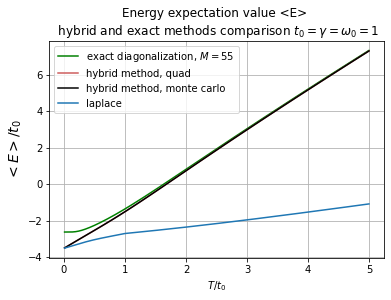

In [410]:
t_0,gamma,w_0= 1,1,0.1
x = np.linspace(0,56,1000)
off_set = 10*w_0
plt.rcParams["figure.figsize"] = (6,4)

plt.plot(T_values2,E_qm, color='g', label ="exact diagonalization, $M=55$")
#plt.plot(T_values,E_qm2, label ="exact diagonalization, $M=25$")
plt.plot(T_values,-Energy_sci-off_set, color='indianred', label ="hybrid method, quad")
plt.plot(T_values,-Energy_mont-off_set, color='black', label ="hybrid method, monte carlo")
plt.plot(T_values2,-E_test-off_set, label ="laplace")
#plt.plot(E_0_vs_M[0],E_0_vs_M[2],'.', label ="momentum basis")
#plt.plot(x,(x*0)+-gamma**2/w_0, label =r'$-\gamma^2/\omega_0$ in units of $\hbar\omega_0$')
plt.title("Energy expectation value <E> \n hybrid and exact methods comparison $t_0=\gamma=\omega_0=1$")
plt.xlabel(xlabel=r'$T/ t_0$')
plt.ylabel(ylabel=r'$<E>/t_0$', fontsize = 14.)
plt.grid()
plt.legend()
plt.savefig("E_hy_vs_qm.png", bbox_inches='tight')

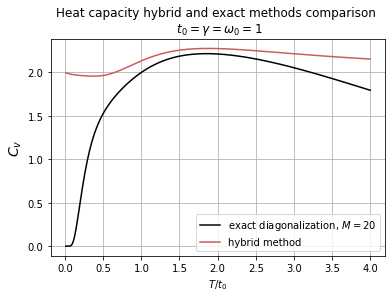

In [81]:

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(T_values,C_v_qm, color='black', label ="exact diagonalization, $M=20$")
#plt.plot(T_values,C_v_qm2, label ="exact diagonalization, $M=45$")
plt.plot(T_values,heat,color='indianred', label ="hybrid method")
#plt.plot(E_0_vs_M[0],E_0_vs_M[2],'.', color='g', label ="momentum basis")
#plt.plot(x,(x*0)+-gamma**2/w_0, label =r'$-\gamma^2/\omega_0$ in units of $\hbar\omega_0$')
plt.title("Heat capacity hybrid and exact methods comparison \n $t_0=\gamma=\omega_0=1$")
plt.xlabel(xlabel=r'$T/ t_0$')
plt.ylabel(ylabel=r'$C_v$', fontsize = 14.)
plt.grid()
plt.legend()
plt.savefig("Cv_hy_vs_qm.png", bbox_inches='tight')

In [30]:
E(t_0,gamma,w_0, 35 , method='monte_carlo',debug=True)

0.004499632842903477
0.004520934144902772


2.439171533004296

In [49]:
Z_hybrid(t_0,gamma,w_0, 1, deriv=1, method='simpson')/Z_hybrid(t_0,gamma,w_0, 1, deriv=0, method='simpson')

1.9280551601516343

In [51]:
E(t_0,gamma,w_0, 1 , method='simpson',debug=True)

0.9280551601516343

In [378]:
q = sy.Symbol('q')
t = sy.Symbol('t', positive=True)
b = sy.Symbol('b', positive=True)
g = sy.Symbol('g', positive=True)
w = sy.Symbol('w', positive=True)

In [379]:
f1 = -b*(w*q**2/2+sy.sqrt(g**2*w*q**2+4*t**2))
f2 = -b*(w*q**2/2-sy.sqrt(g**2*w*q**2+4*t**2))

In [380]:
q_0 = sy.solve(f1.diff(q),q)[2]
q_1 = sy.solve(f2.diff(q),q)[2]


In [381]:
s1 = f1.diff(q)
s2 = f2.diff(q)

In [382]:
h1 = s1.diff(q)
h2 = s2.diff(q)

In [383]:
aprox = (sy.exp(f1.subs(q,q_0)))*\
sy.sqrt(abs(sy.pi*2/h1.subs(q, q_0)))\
+ sy.exp(f2.subs(q,q_0)) *sy.sqrt(abs(sy.pi*2/h2.subs(q, q_0)))

In [384]:
Laplace_aprox = sy.lambdify((b,t,w,g), aprox, 'numpy')
zero =  g**2/(2*w) - 3/2 * 1/b

In [385]:
Laplace_aprox(1,1,1,1)

19.478749475339637

In [386]:
E_Laplace_aprox = sy.lambdify((b,t,w,g), (sy.log(aprox).diff(b)*-1)+zero, 'numpy')

In [387]:
E_Laplace_aprox(2,1,1,1)

-2.4720224581451684

In [388]:
T_values2 = np.concatenate((np.linspace(0.01,1,100),np.linspace(1,3,100)))
beta_values2 = 1/(T_values2)
E_test = np.array([E_Laplace_aprox(beta_values2[i],1,0.1,1) for i in range(len(beta_values2))])
